### To be run in colab

In [1]:
# mount the google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [3]:
!pip install --quiet git+https://github.com/theislab/scgen.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Import the metric -- scib

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install --quiet scib
import scib

In [6]:
!pip install --quiet louvain
import louvain

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<ipython-input-6-bf0d4c071418>:2: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be

### Import the necessary library

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

In [2]:
import os
import tempfile

import gdown
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.external import CellAssign

In [3]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


### read the data

In [4]:
# adata = anndata.read_h5ad("/content/drive/MyDrive/scdata/Lung_atlas_public/Lung_atlas_public.h5ad")
adata = anndata.read_h5ad("../human_pancreas_norm.h5ad")
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'

## SingleR

In [5]:
predictions = pd.read_csv("../R_human_pancreas/labels/singleR_human_pancreas_predict_labels.csv")
adata.obs['predict_labels'] = predictions['predict_labels'].values

In [6]:
adata.obs['predict_labels'] = adata.obs['predict_labels'].astype('category')

In [7]:
adata.obs['predict_labels']

D101_5                   Neurons
D101_43         Epithelial cells
D101_93                  Neurons
D102_4                   Neurons
D172444_23     Endothelial cells
                     ...        
Sample_1594              Neurons
Sample_1595              Neurons
Sample_1597     Epithelial cells
Sample_1598              Neurons
Sample_1600              Neurons
Name: predict_labels, Length: 16382, dtype: category
Categories (26, object): ['Adipocytes', 'Astrocytes', 'B-cells', 'CD4+ T-cells', ..., 'Pericytes', 'Skeletal muscle', 'Smooth muscle', 'Unknown']

In [8]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='tech')
adata = adata[:, adata.var['highly_variable']]

In [9]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

# scANVI

In [14]:
# scVI
adata = adata.copy()
adata.layers['counts'] = adata.X
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

Epoch 273/273: 100%|██████████| 273/273 [08:26<00:00,  1.85s/it, v_num=1, train_loss_step=745, train_loss_epoch=766]

INFO: `Trainer.fit` stopped: `max_epochs=273` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=273` reached.


Epoch 273/273: 100%|██████████| 273/273 [08:26<00:00,  1.85s/it, v_num=1, train_loss_step=745, train_loss_epoch=766]


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

In [9]:
import scvi

# Set up the AnnData object
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="tech")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

# Now you can use the loaded model for further analysis or inference
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [37]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

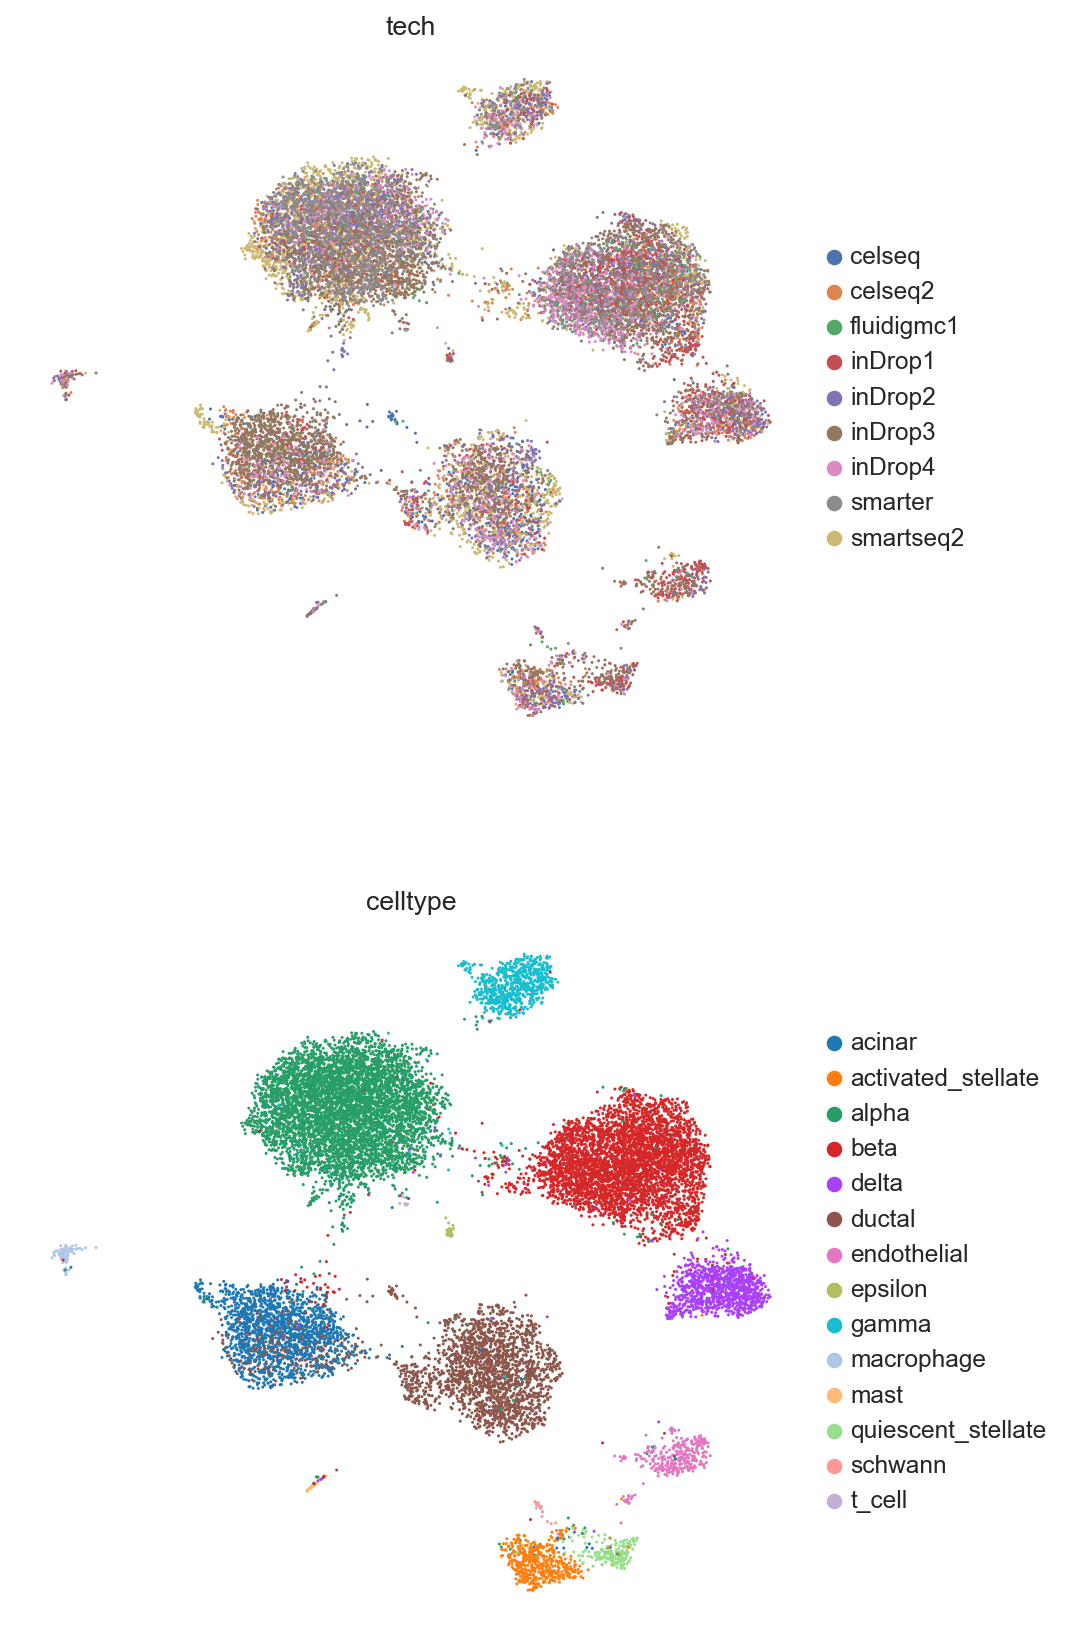

In [40]:
sc.pl.umap(adata, color=["tech", "celltype"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [18]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="predict_labels",
    unlabeled_category="Unknown",
)

In [19]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|█| 20/20 [02:09<00:00,  6.61s/it, v_num=1, train_loss_step=1.3

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [02:09<00:00,  6.47s/it, v_num=1, train_loss_step=1.3


In [20]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [21]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict['X_scANVI'] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [22]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

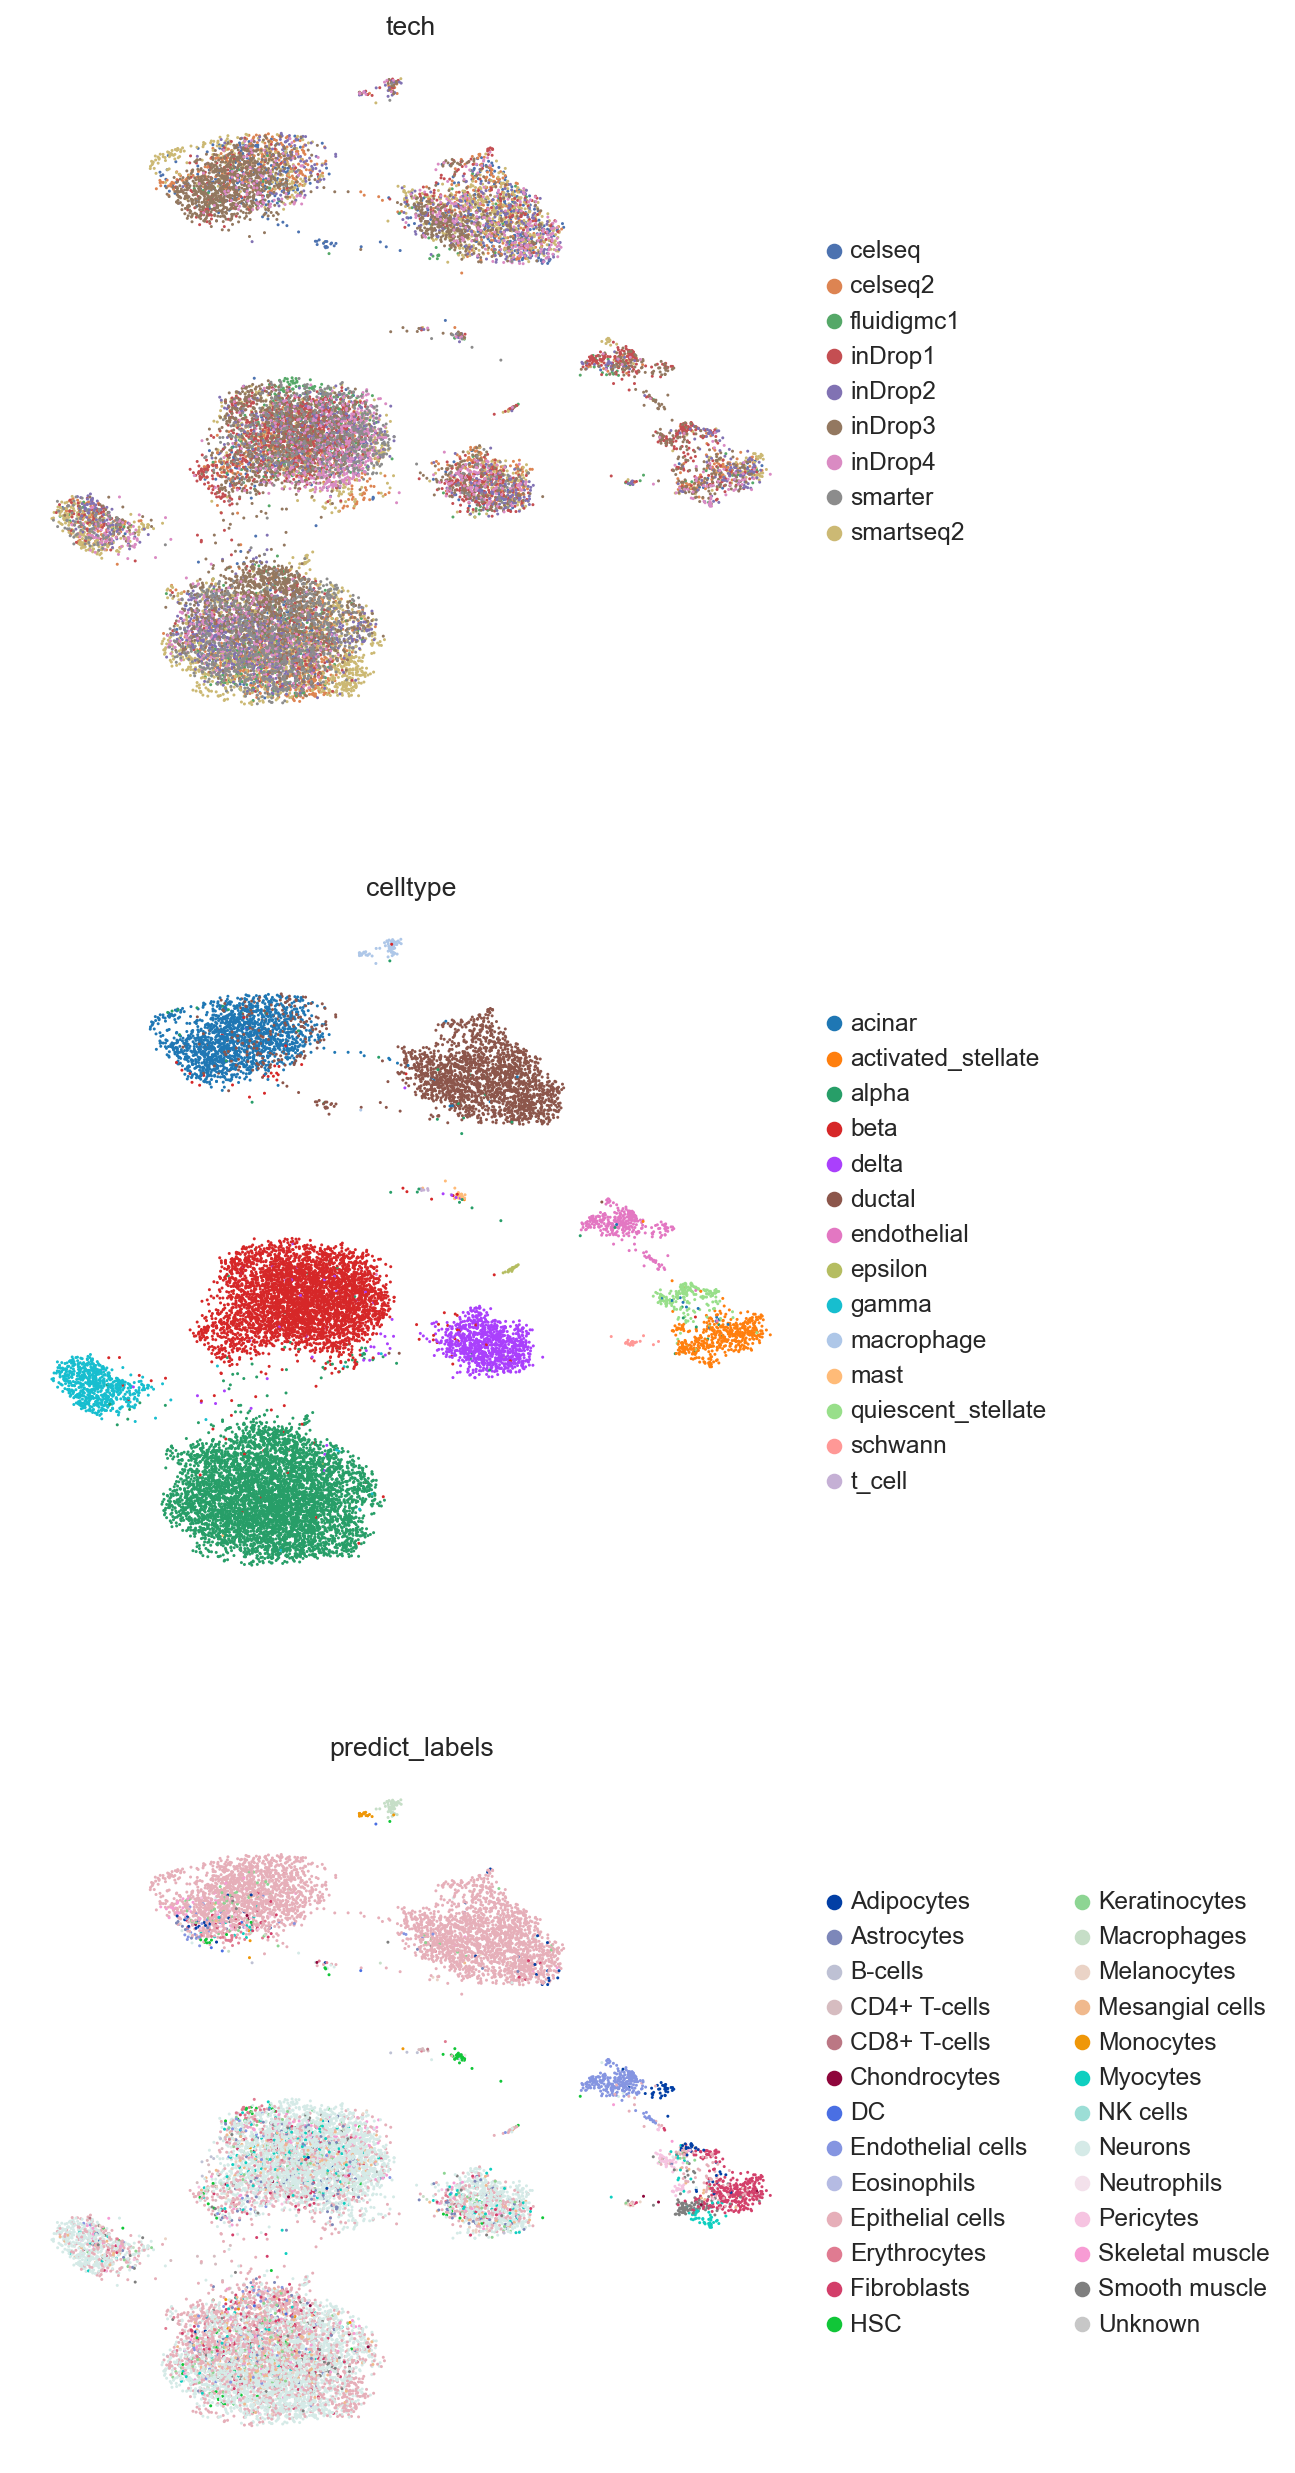

In [23]:
sc.pl.umap(adata, color=["tech", "celltype", "predict_labels"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [24]:
train = adata.copy()

### Preprocessing Data

In [25]:
scgen.SCGEN.setup_anndata(train, batch_key="tech", labels_key="predict_labels")

## Creating and Training the model¶

In [26]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 28/100:  28%|▎| 28/100 [04:33<11:43,  9.76s/it, v_num=1, train_loss_step=1
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 996.541. Signaling Trainer to stop.


## Batch-Removal

In [27]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 16382 × 2000
    obs: 'tech', 'celltype', 'size_factors', 'predict_labels', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'concat_batch'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [28]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [29]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

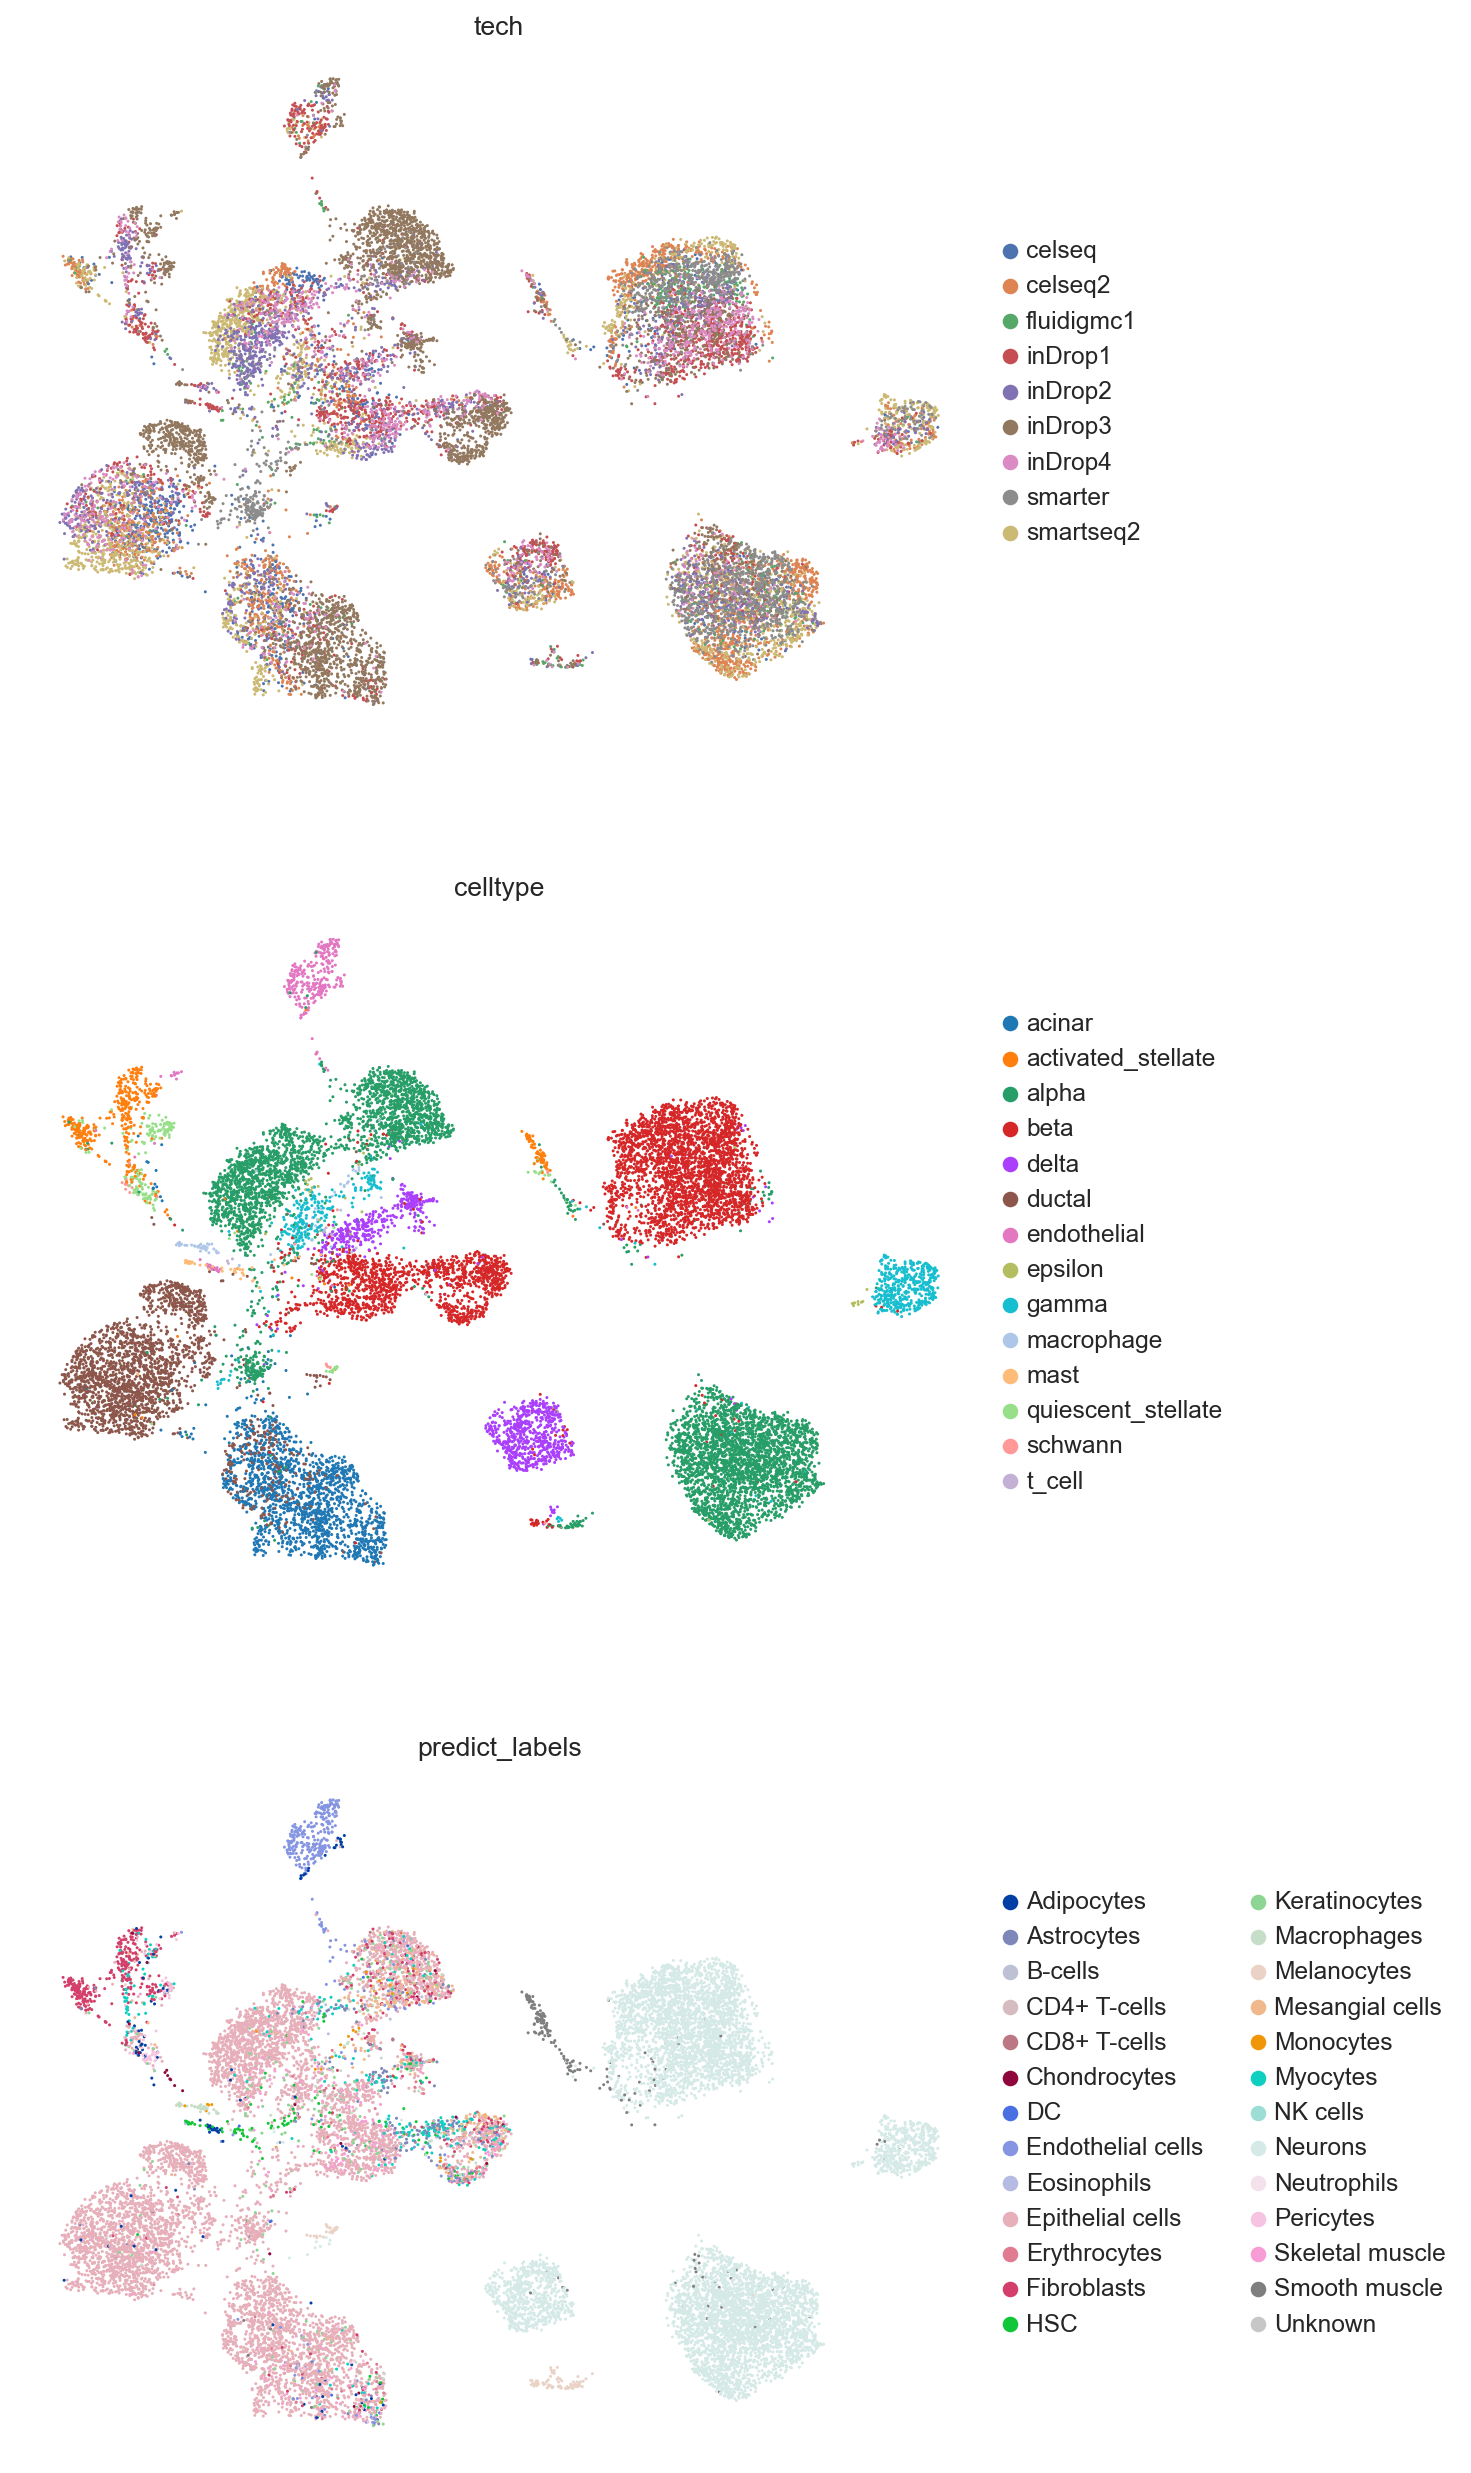

In [30]:
sc.pl.umap(corrected_adata, color=['tech', 'celltype', 'predict_labels'], wspace=0.4, frameon=False, ncols=1)

# STACAS

Semi-supervised integration results

In [11]:
pca_embeddings = pd.read_csv('../R_human_pancreas/embeddings/human_pancreas_stacas_embeddings_singleR.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
# Collect embeddings
embeddings_dict["X_stacas"] = adata.obsm['X_stacas']

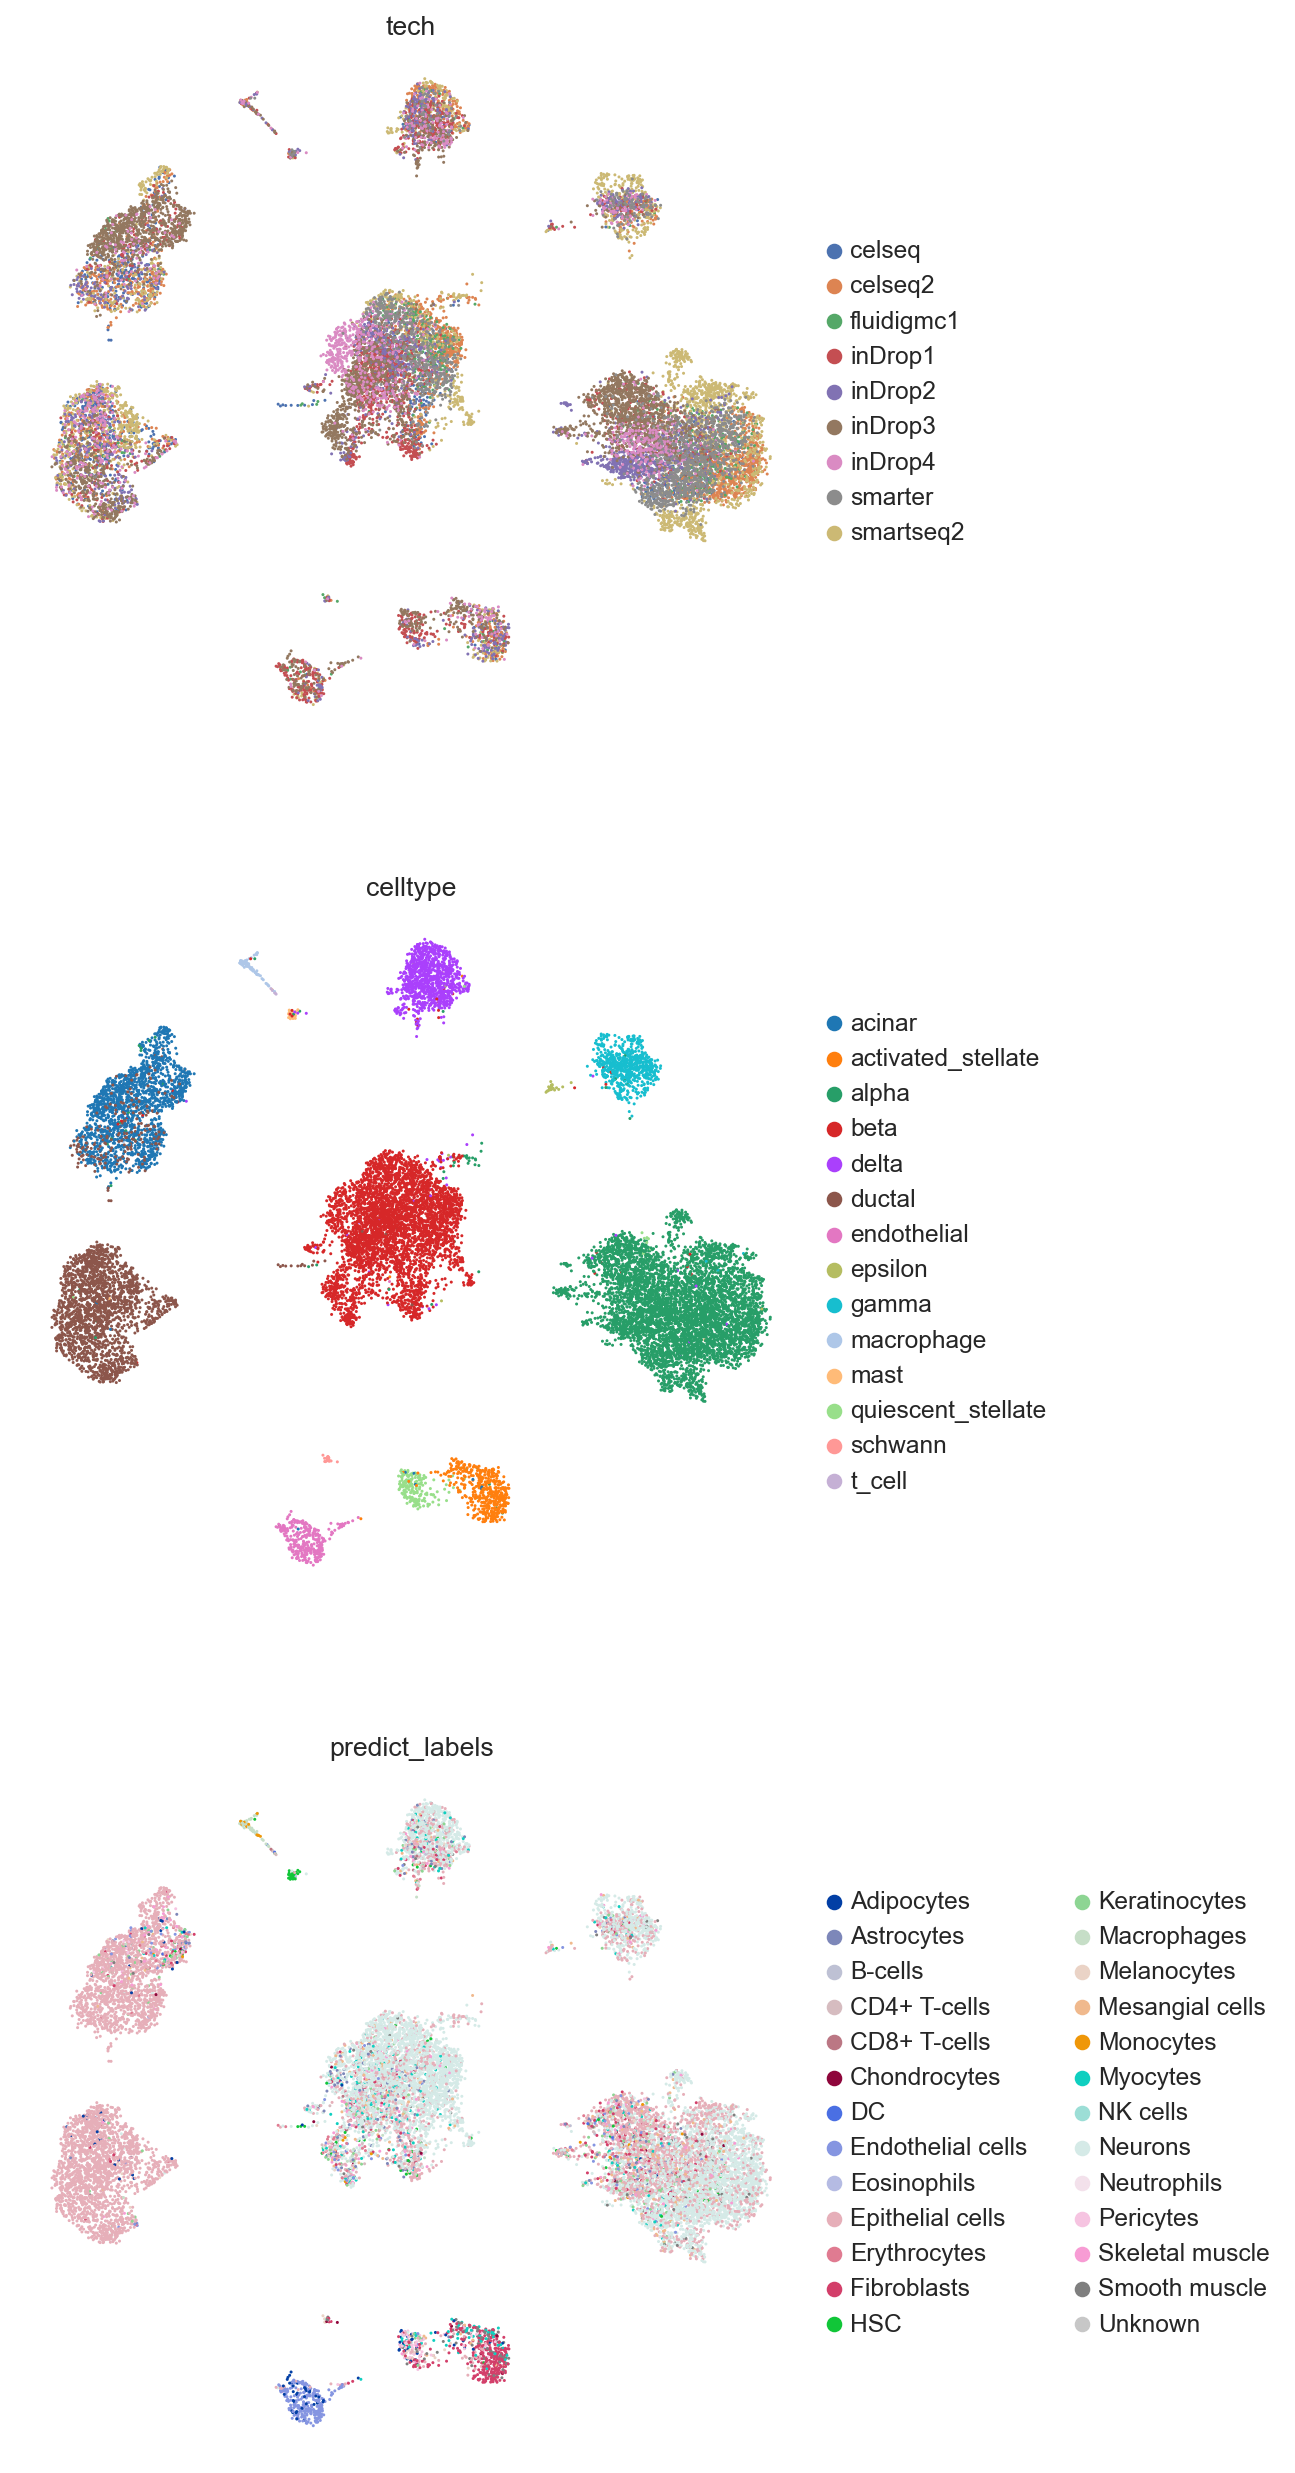

In [13]:
sc.pl.umap(adata, color=["tech", "celltype", "predict_labels"], frameon=False, ncols=1)

In [14]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/singleR_human_pancreas.csv")


# Metric Evaluation

## read the embeddings

In [15]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("../embeddings/singleR_human_pancreas.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [16]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="celltype")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_scANVI')

resolution: 0.1, nmi: 0.8991930595092287
resolution: 0.2, nmi: 0.9093668696635147
resolution: 0.3, nmi: 0.9092057230201614
resolution: 0.4, nmi: 0.9099669285740958
resolution: 0.5, nmi: 0.9074215313257338
resolution: 0.6, nmi: 0.9039829100474799
resolution: 0.7, nmi: 0.8996533385701395
resolution: 0.8, nmi: 0.8567948059196295
resolution: 0.9, nmi: 0.8464530204835959
resolution: 1.0, nmi: 0.8096530745711307
resolution: 1.1, nmi: 0.7959316795739129
resolution: 1.2, nmi: 0.7943544882910579
resolution: 1.3, nmi: 0.7752668897638739
resolution: 1.4, nmi: 0.7494487101226527
resolution: 1.5, nmi: 0.7312029500862146
resolution: 1.6, nmi: 0.7165964199678043
resolution: 1.7, nmi: 0.7089873026014732
resolution: 1.8, nmi: 0.7018745089797167
resolution: 1.9, nmi: 0.6840362422975353
resolution: 2.0, nmi: 0.6834207066243666
optimised clustering against celltype
optimal cluster resolution: 0.4
optimal score: 0.9099669285740958
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on

In [17]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="celltype")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_scgen')

resolution: 0.1, nmi: 0.6688546111295737
resolution: 0.2, nmi: 0.7643150984740531
resolution: 0.3, nmi: 0.7362411157764199
resolution: 0.4, nmi: 0.7428527536736466
resolution: 0.5, nmi: 0.7434722947163646
resolution: 0.6, nmi: 0.7432406580534742
resolution: 0.7, nmi: 0.7329909073955038
resolution: 0.8, nmi: 0.732679155282948
resolution: 0.9, nmi: 0.7339163094607338
resolution: 1.0, nmi: 0.7345730449636078
resolution: 1.1, nmi: 0.7182430934841258
resolution: 1.2, nmi: 0.716827704037463
resolution: 1.3, nmi: 0.7071121936880993
resolution: 1.4, nmi: 0.7008800837817724
resolution: 1.5, nmi: 0.6951820658002855
resolution: 1.6, nmi: 0.6738751391815996
resolution: 1.7, nmi: 0.6653599877092857
resolution: 1.8, nmi: 0.6640605942105647
resolution: 1.9, nmi: 0.6575998709686665
resolution: 2.0, nmi: 0.6562949981852243
optimised clustering against celltype
optimal cluster resolution: 0.2
optimal score: 0.7643150984740531
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on r

In [18]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="celltype")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='tech', label_key = 'celltype', embed = 'X_scgen')

resolution: 0.1, nmi: 0.9214519608693053
resolution: 0.2, nmi: 0.9240107039403141
resolution: 0.3, nmi: 0.9252061220130381
resolution: 0.4, nmi: 0.8925859392539207
resolution: 0.5, nmi: 0.8331267010036616
resolution: 0.6, nmi: 0.8137012192756607
resolution: 0.7, nmi: 0.8226341563170928
resolution: 0.8, nmi: 0.8191137405476187
resolution: 0.9, nmi: 0.7992624288523708
resolution: 1.0, nmi: 0.7772864842088899
resolution: 1.1, nmi: 0.7527677303707155
resolution: 1.2, nmi: 0.7395859111545627
resolution: 1.3, nmi: 0.7120722294801263
resolution: 1.4, nmi: 0.7017905941611138
resolution: 1.5, nmi: 0.6991948452173679
resolution: 1.6, nmi: 0.6997367405060089
resolution: 1.7, nmi: 0.6952875891659817
resolution: 1.8, nmi: 0.6885945584818629
resolution: 1.9, nmi: 0.6888536124764912
resolution: 2.0, nmi: 0.6870707678500294
optimised clustering against celltype
optimal cluster resolution: 0.3
optimal score: 0.9252061220130381
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on

In [19]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df.to_csv("../metrics/human_pancreas_metrics_singleR.csv", index=True)